# **Feature Engineering**

## Objectives

* Engineering features for the Regression model

## Inputs

* inputs/datasets/cleaned/TrainSet.csv
* inputs/datasets/cleaned/TestSet.csv

## Outputs

* generate a list of variables to engineer 

## Additional Comments

* Feature Engineering Transformers
    *


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/housing-price-data-ml/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/housing-price-data-ml'

# Load data

Train set

In [4]:
import pandas as pd
train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head(3)

1stFlrSF  GarageArea  GarageYrBlt  GrLivArea KitchenQual  OverallQual  \
0      1828         774       2007.0       1828          Gd            9   
1       894         308       1962.0        894          TA            5   
2       964         432       1921.0        964          TA            5   

   TotalBsmtSF  YearBuilt  YearRemodAdd  SalePrice  
0         1822       2007          2007     314813  
1          894       1962          1962     109500  
2          876       1921          2006     163500

Test Set

In [5]:
test_set_path = 'outputs/datasets/cleaned/TestSetCleaned.csv'
TestSet = pd.read_csv(test_set_path)
TestSet.head(3)

1stFlrSF  GarageArea  GarageYrBlt  GrLivArea KitchenQual  OverallQual  \
0      2515         484       1975.0       2515          TA            6   
1       958         240       1941.0       1578          Fa            6   
2       979         352       1950.0       1203          Gd            5   

   TotalBsmtSF  YearBuilt  YearRemodAdd  SalePrice  
0         2035       1957          1975     200624  
1          806       1941          1950     133000  
2          709       1950          1950     110000

---

# Data Exploration

In [6]:
from pandas_profiling import ProfileReport
pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---

# Feature Engineering

Custom function from Code Institute course material.

In [7]:
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


## Categorical Encoding

KitchenQual will need to be converted since it's a categorical variable

In [8]:
var_to_categorically_encode = (TrainSet.select_dtypes(
    include=['object']).columns.to_list())

var_to_categorically_encode


['KitchenQual']

In [9]:
df_engineering = TrainSet[var_to_categorically_encode].copy()
df_engineering.head(3)

KitchenQual
0          Gd
1          TA
2          TA

* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_ordinal_encoder'] 



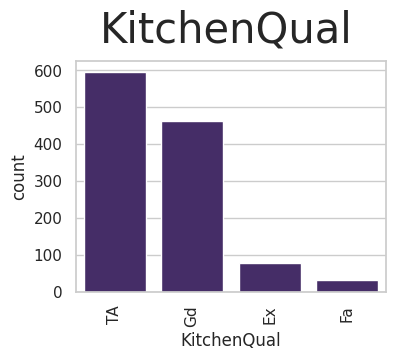

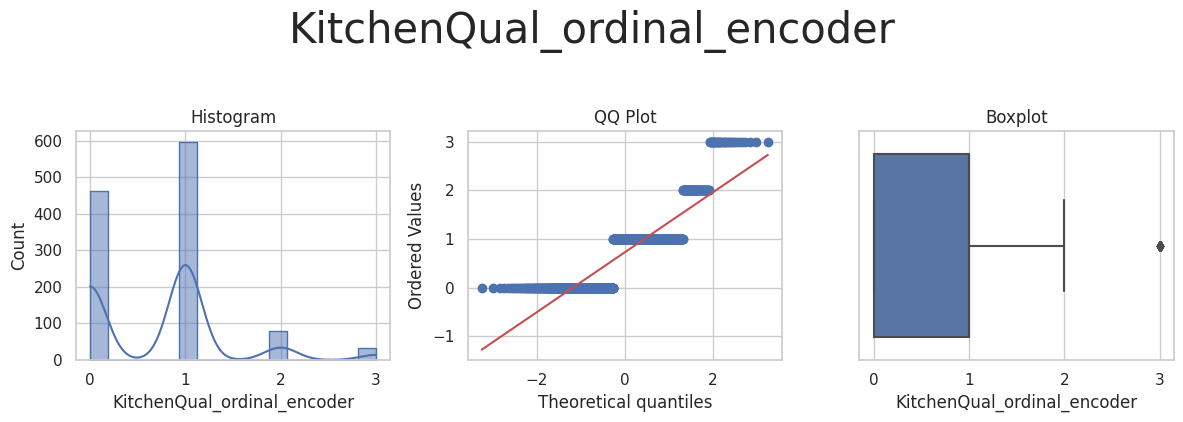

In [10]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='ordinal_encoder')

In [11]:
encoder = OrdinalEncoder(encoding_method='arbitrary', variables = var_to_categorically_encode)
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.transform(TestSet)

print("* Categorical encoding - ordinal transformation done!")

* Categorical encoding - ordinal transformation done!


## Numerical Tranformation

In [12]:
var_to_numercally_transform = ['1stFlrSF', 'GarageArea', 'GarageYrBlt', 'GrLivArea',
                              'OverallQual', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd']

var_to_numercally_transform


['1stFlrSF',
 'GarageArea',
 'GarageYrBlt',
 'GrLivArea',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd']

In [13]:
df_engineering = TrainSet[var_to_numercally_transform].copy()
df_engineering.head(3)

1stFlrSF  GarageArea  GarageYrBlt  GrLivArea  OverallQual  TotalBsmtSF  \
0      1828         774       2007.0       1828            9         1822   
1       894         308       1962.0        894            5          894   
2       964         432       1921.0        964            5          876   

   YearBuilt  YearRemodAdd  
0       2007          2007  
1       1962          1962  
2       1921          2006

* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_log_e', '1stFlrSF_log_10', '1stFlrSF_reciprocal', '1stFlrSF_power', '1stFlrSF_box_cox', '1stFlrSF_yeo_johnson'] 



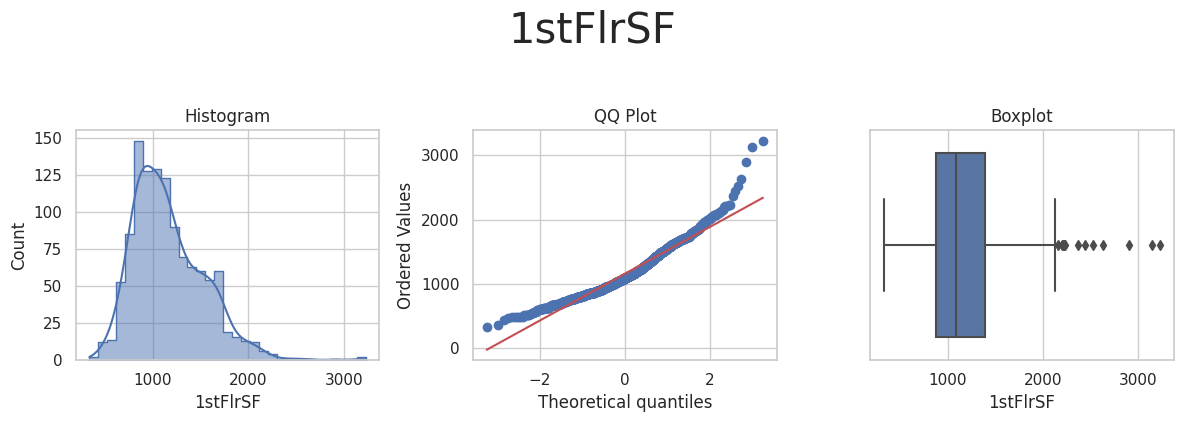

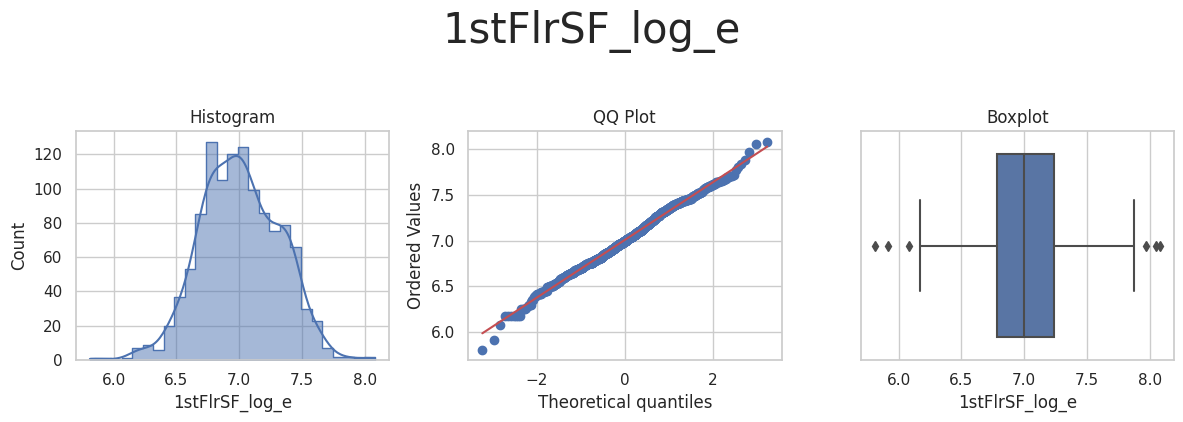

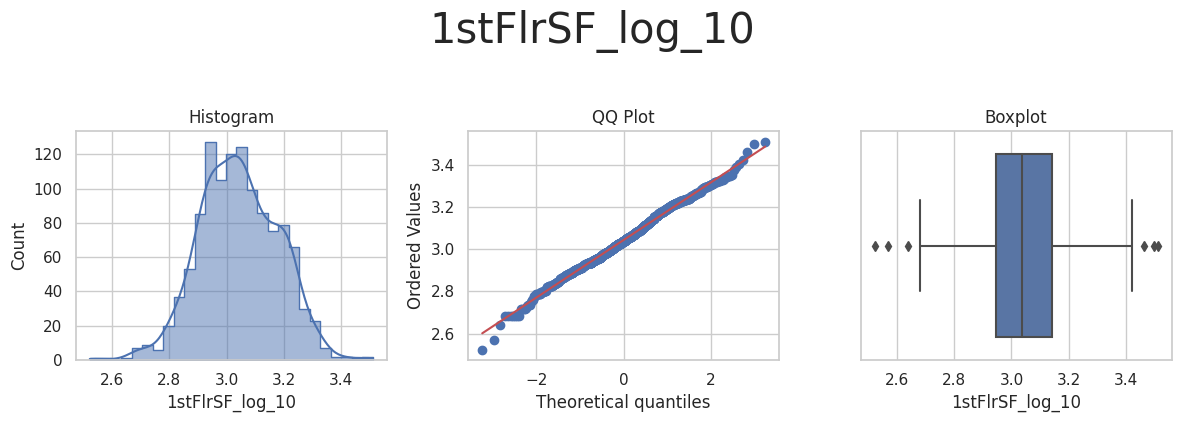

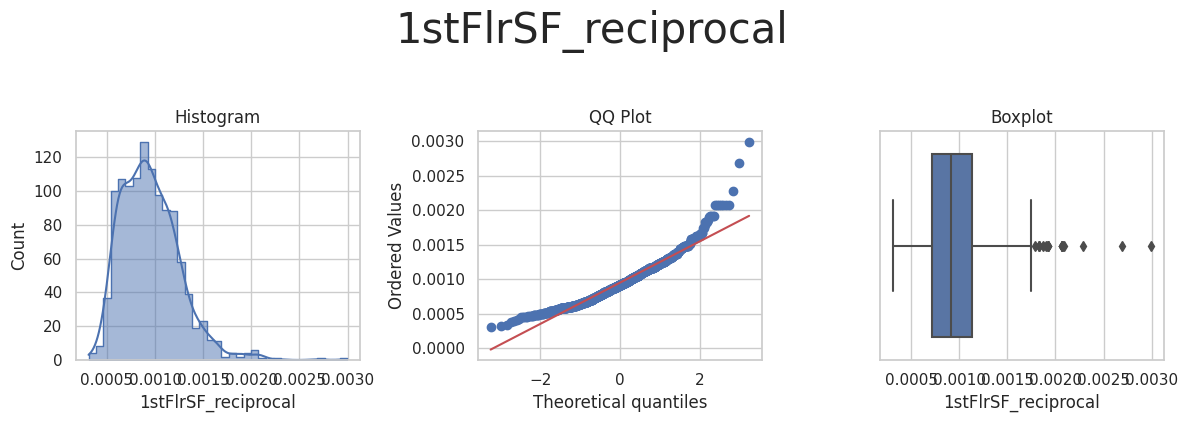

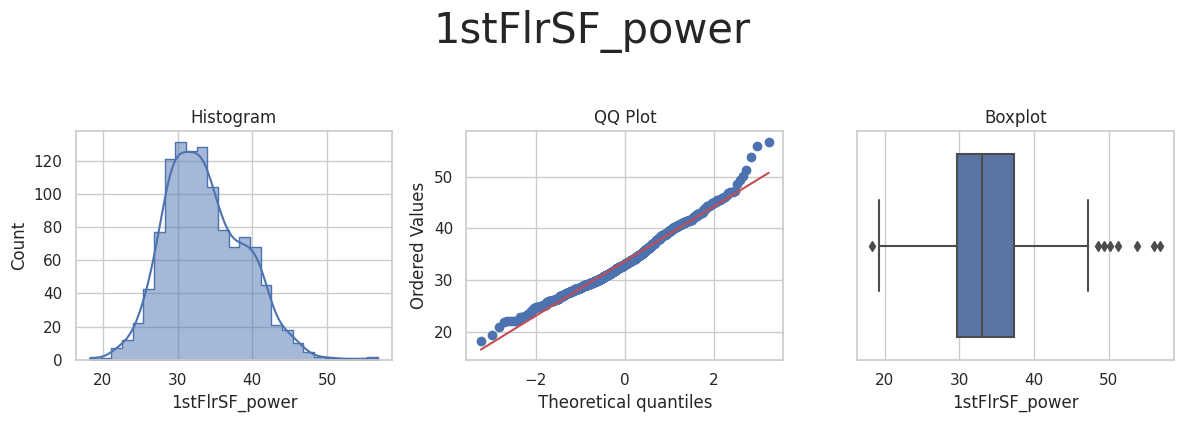

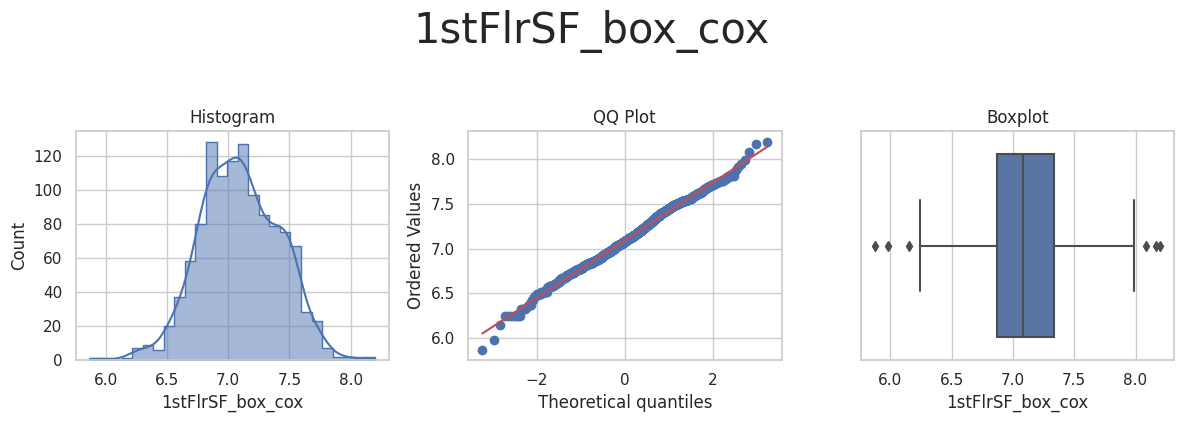

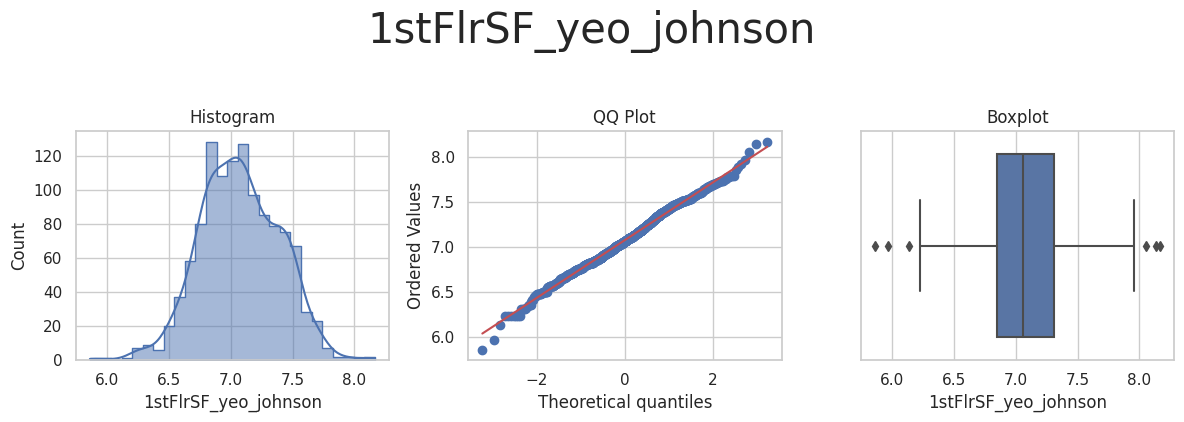



* Variable Analyzed: GarageArea
* Applied transformation: ['GarageArea_power', 'GarageArea_yeo_johnson'] 



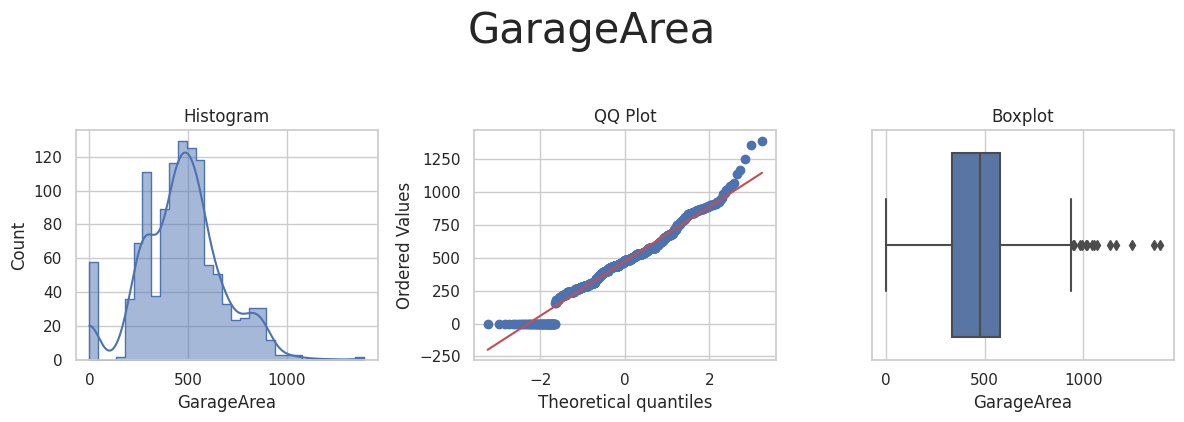

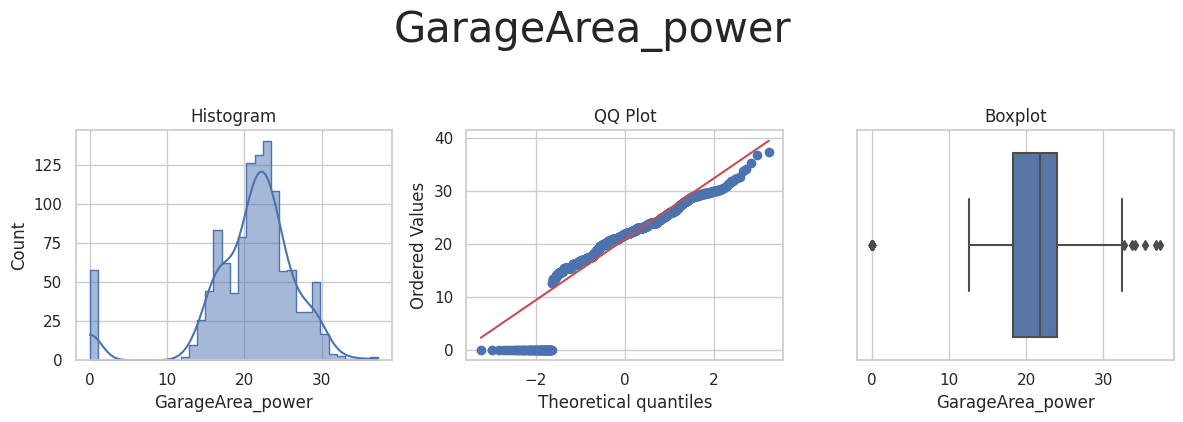

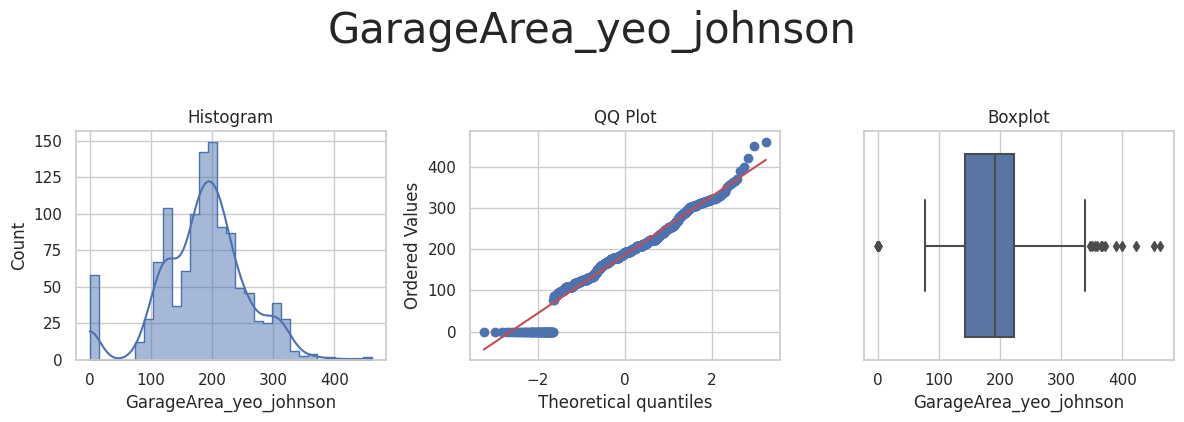



* Variable Analyzed: GarageYrBlt
* Applied transformation: ['GarageYrBlt_log_e', 'GarageYrBlt_log_10', 'GarageYrBlt_reciprocal', 'GarageYrBlt_power', 'GarageYrBlt_box_cox', 'GarageYrBlt_yeo_johnson'] 



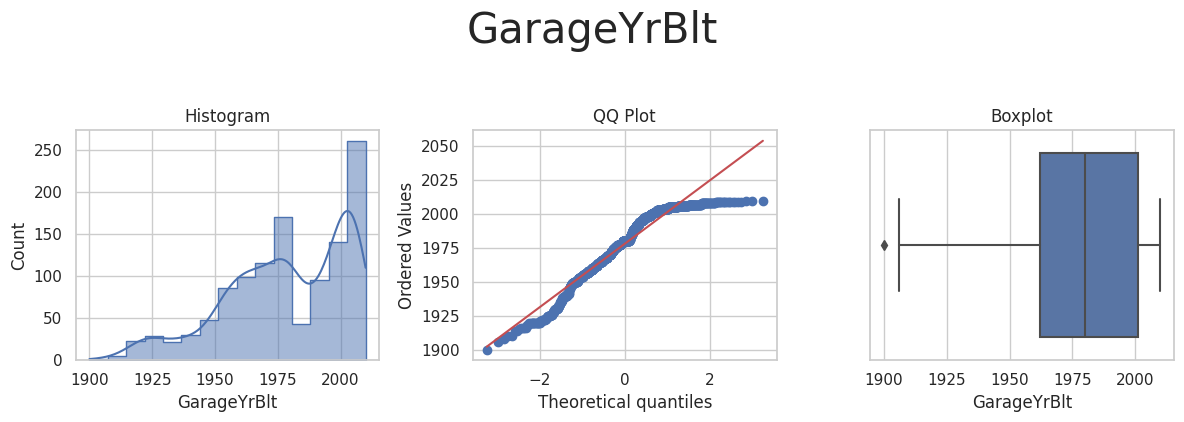

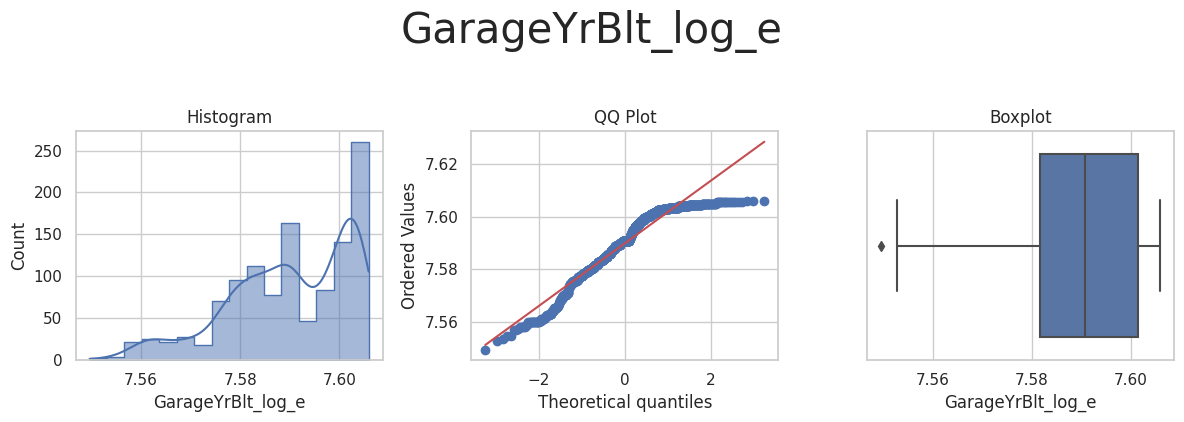

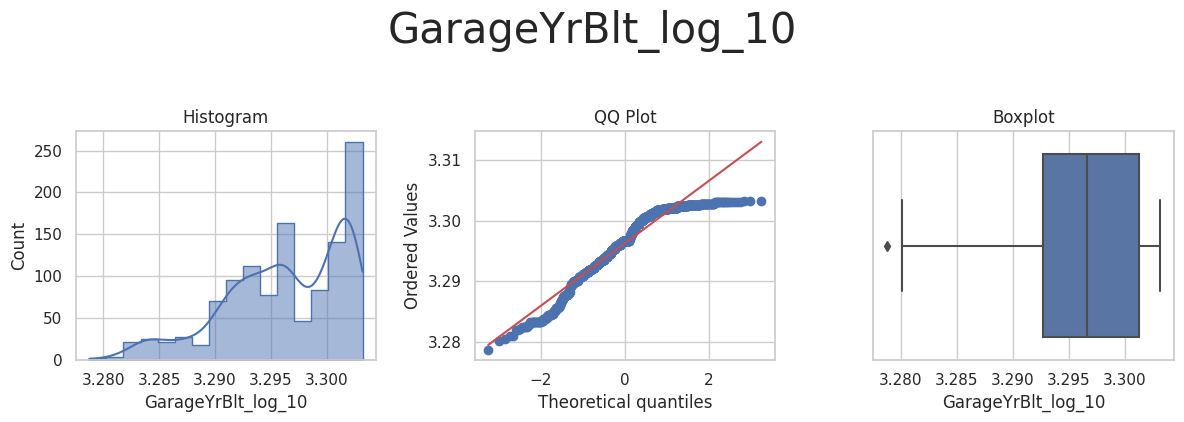

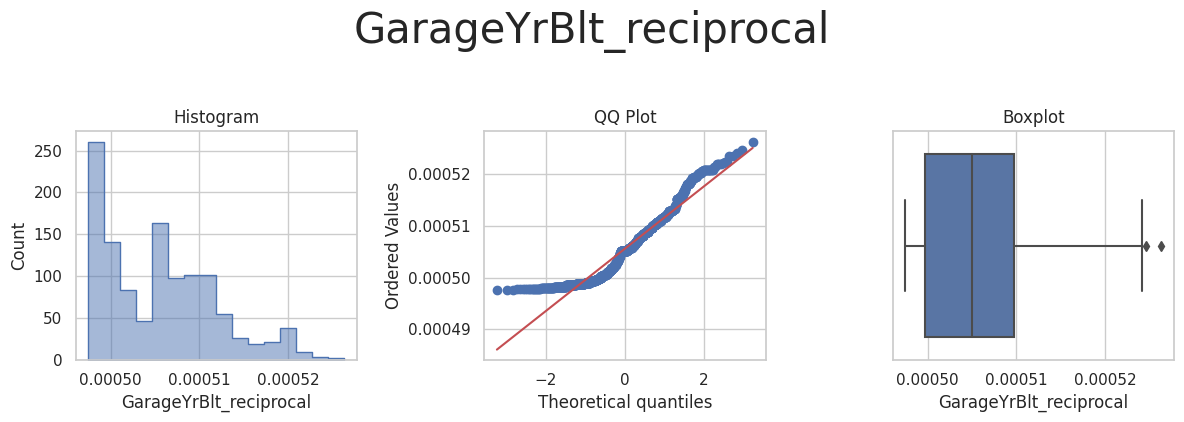

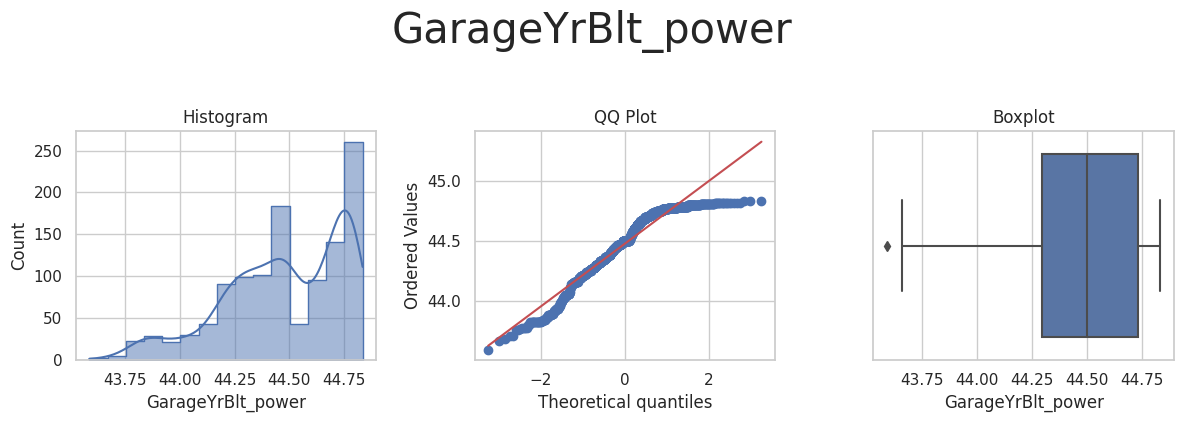

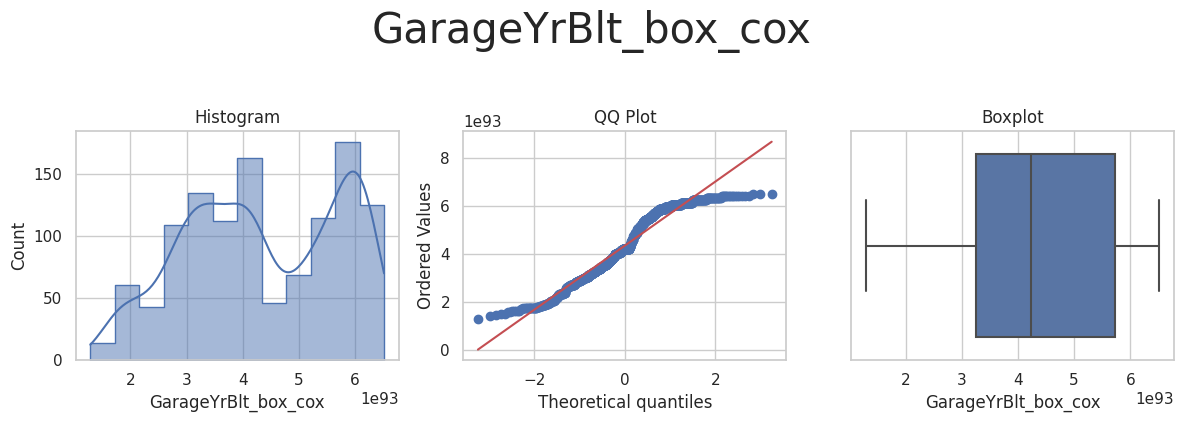

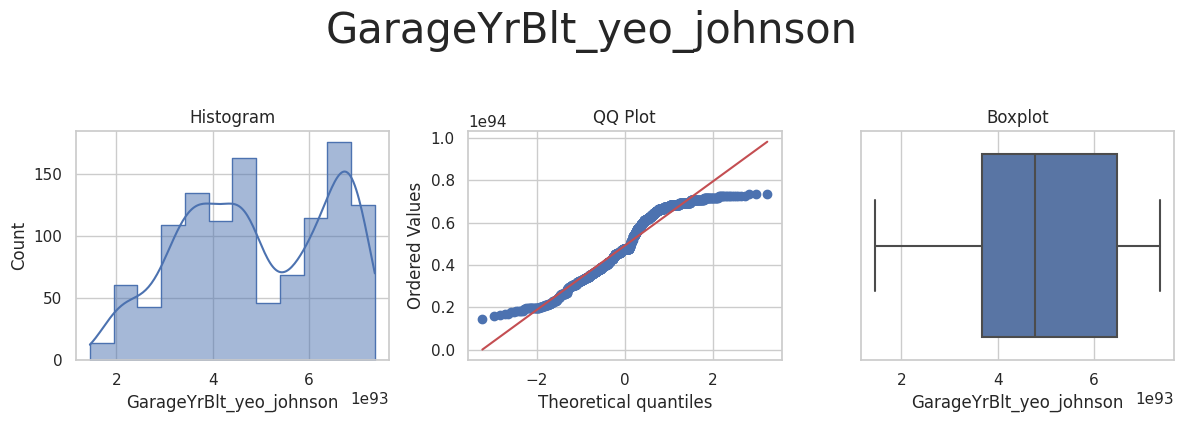



* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_log_e', 'GrLivArea_log_10', 'GrLivArea_reciprocal', 'GrLivArea_power', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson'] 



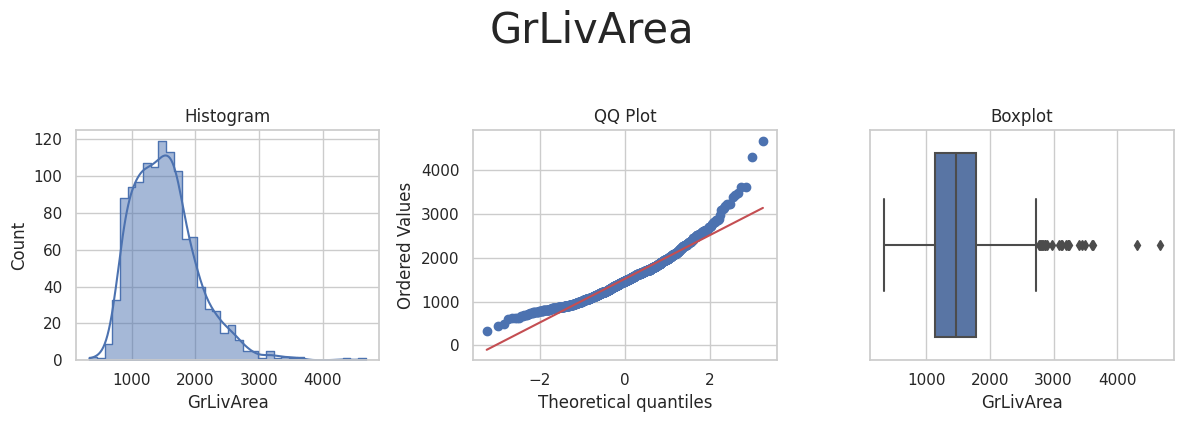

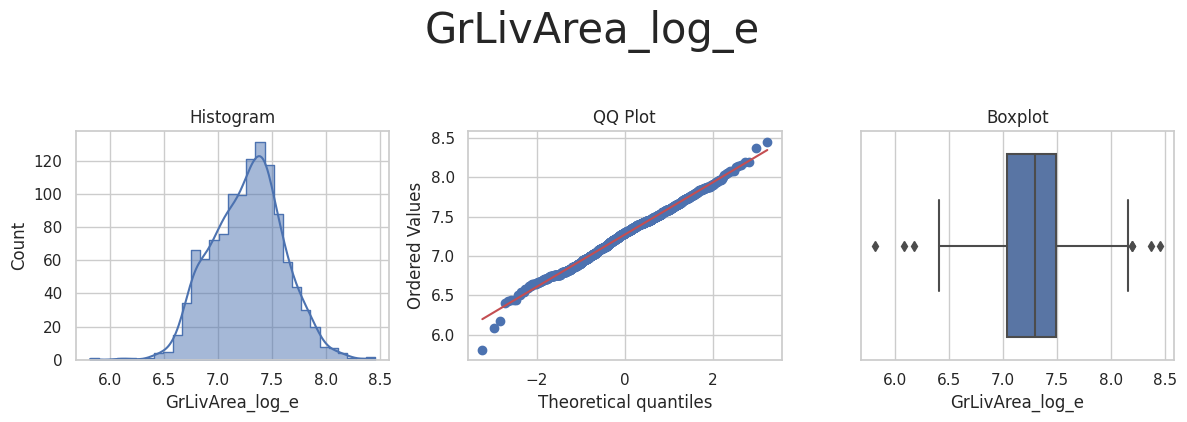

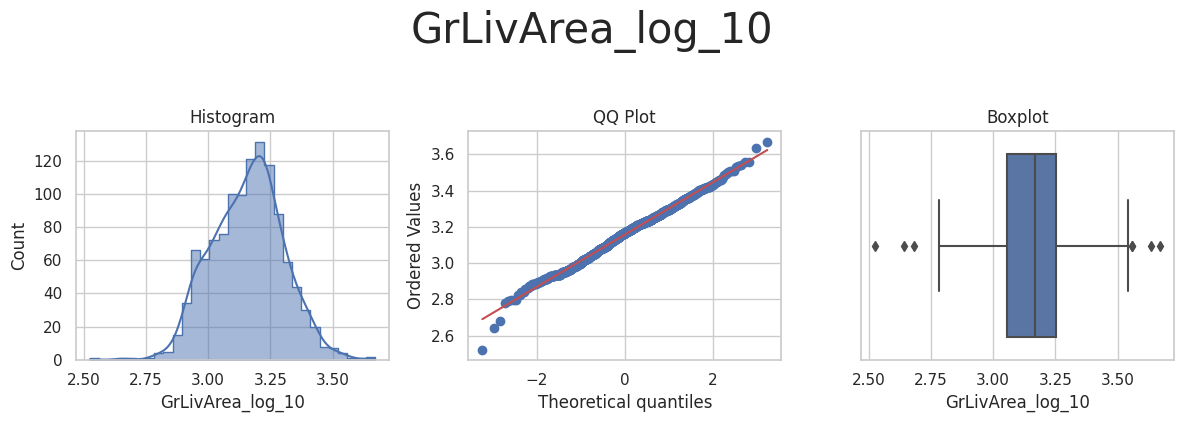

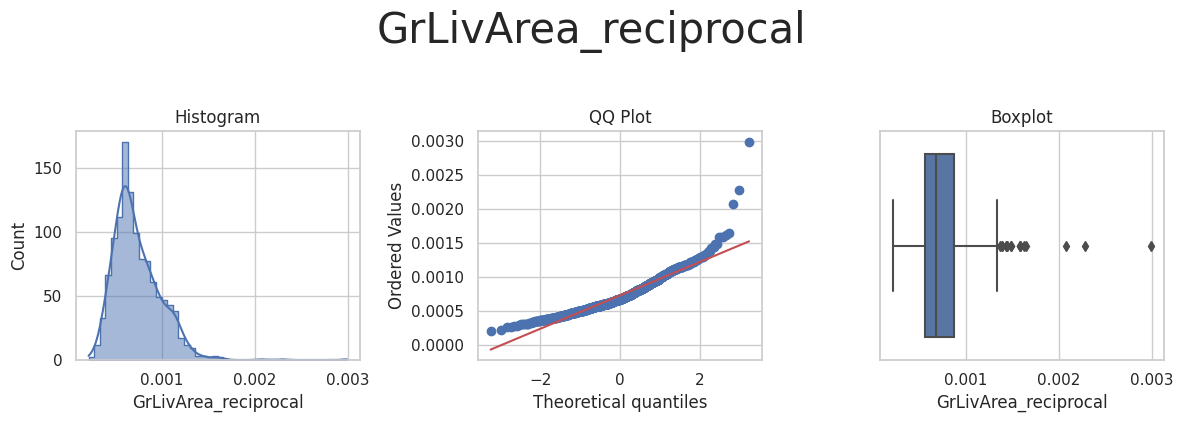

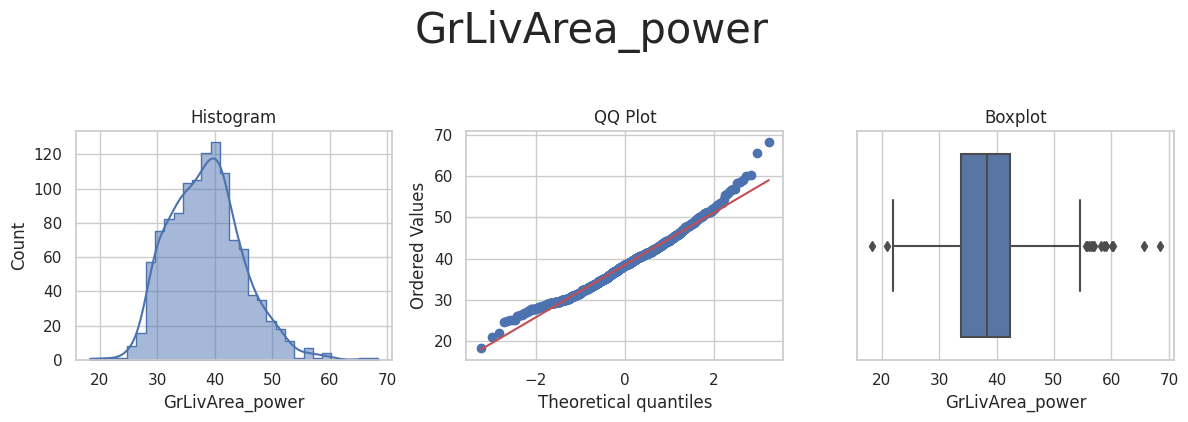

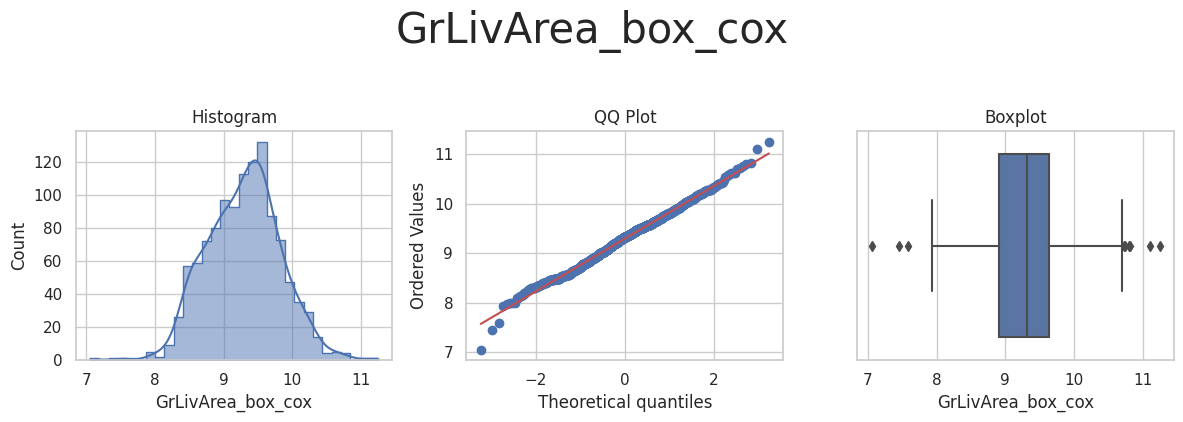

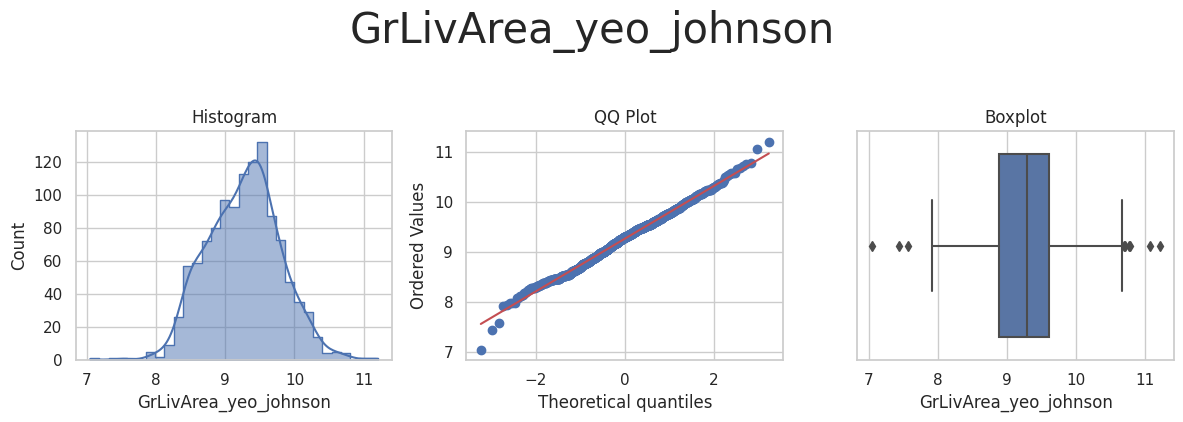



* Variable Analyzed: OverallQual
* Applied transformation: ['OverallQual_log_e', 'OverallQual_log_10', 'OverallQual_reciprocal', 'OverallQual_power', 'OverallQual_box_cox', 'OverallQual_yeo_johnson'] 



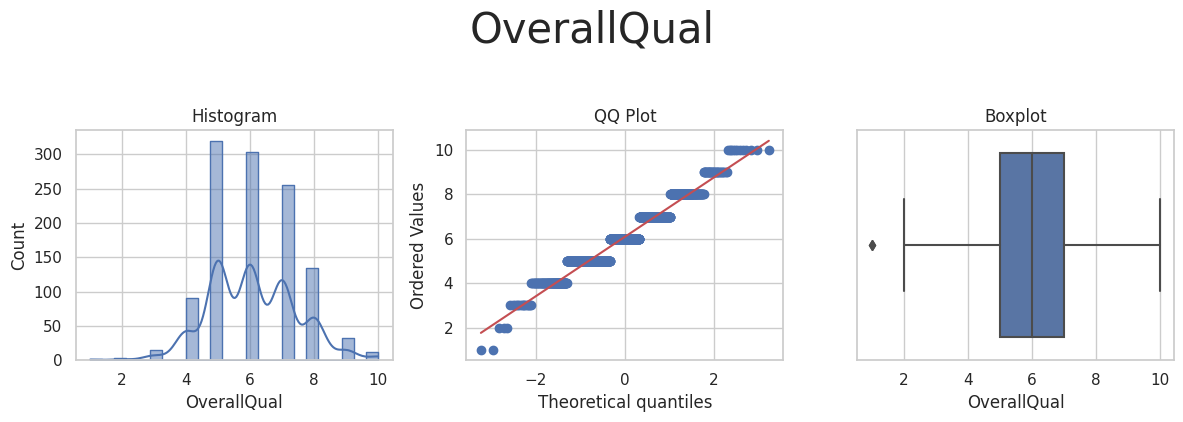

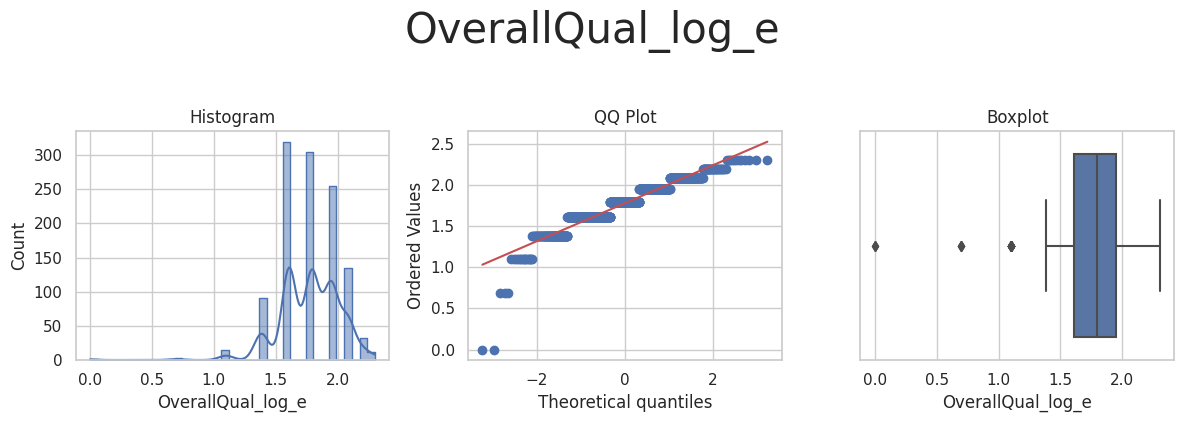

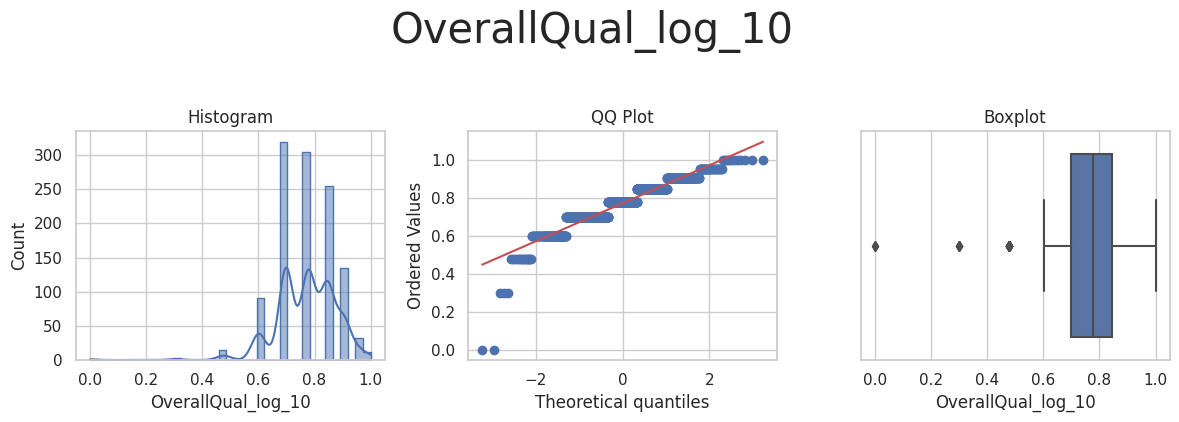

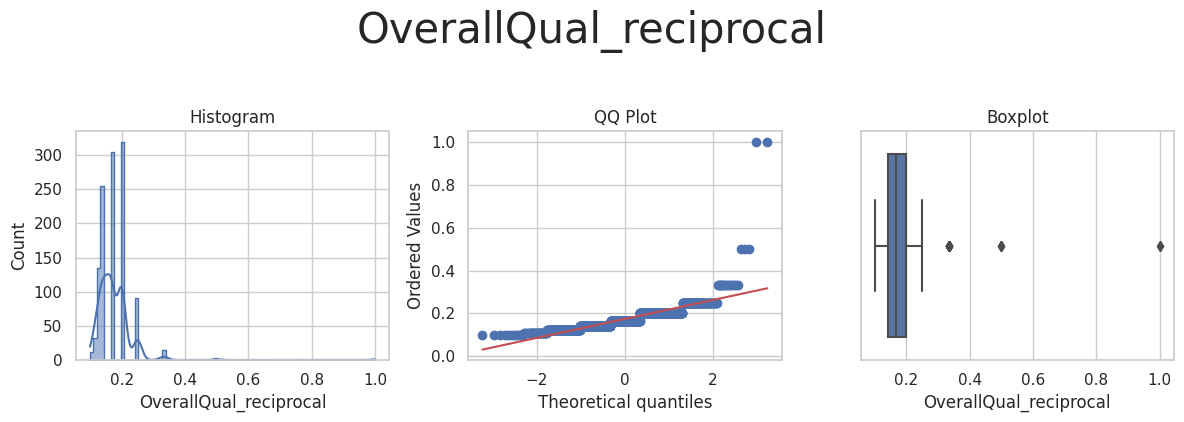

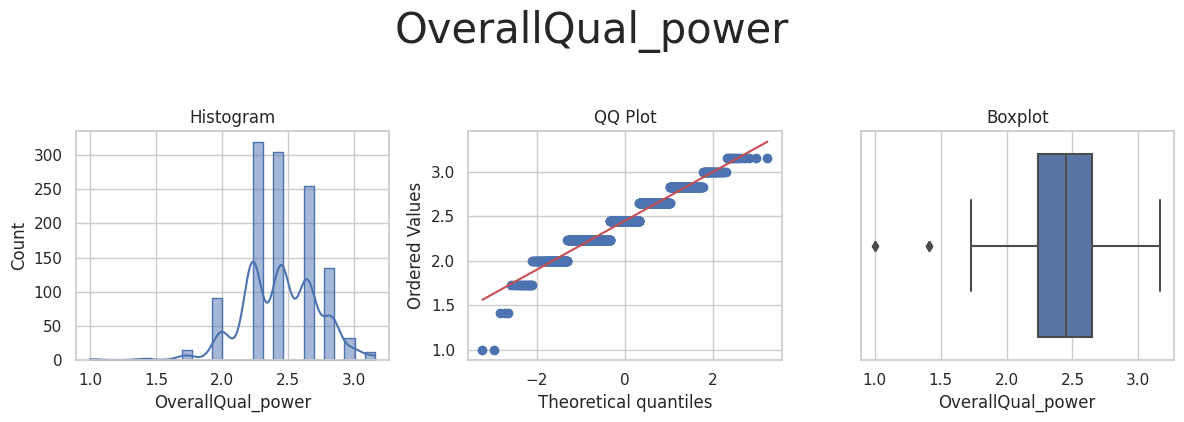

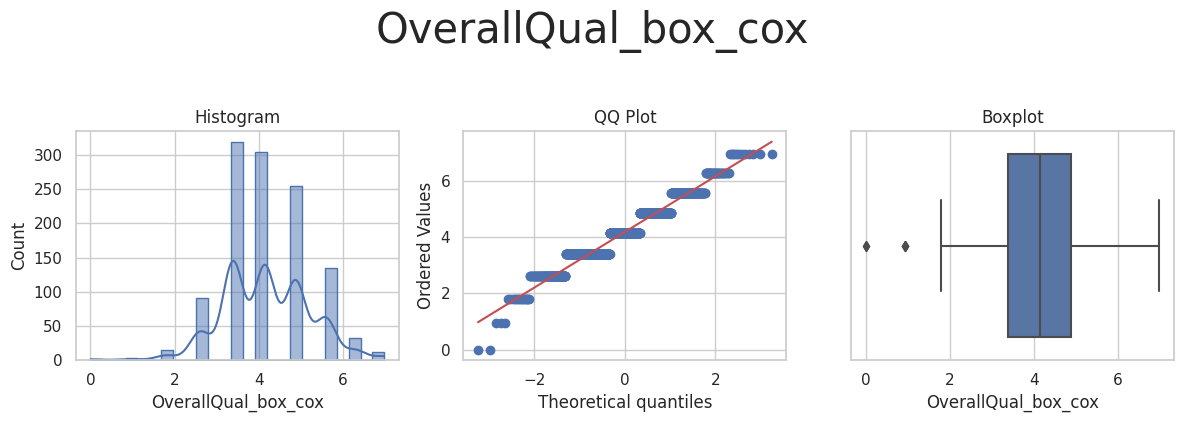

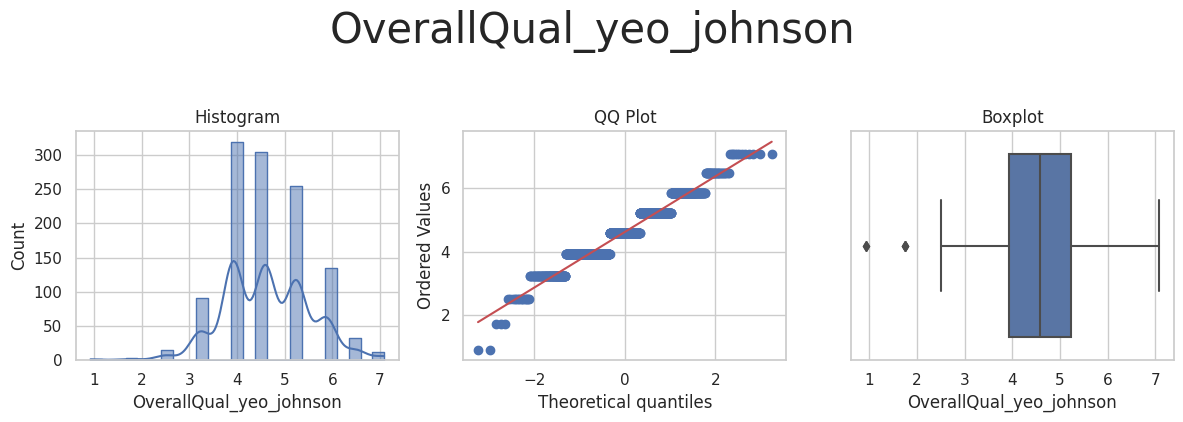



* Variable Analyzed: TotalBsmtSF
* Applied transformation: ['TotalBsmtSF_power', 'TotalBsmtSF_yeo_johnson'] 



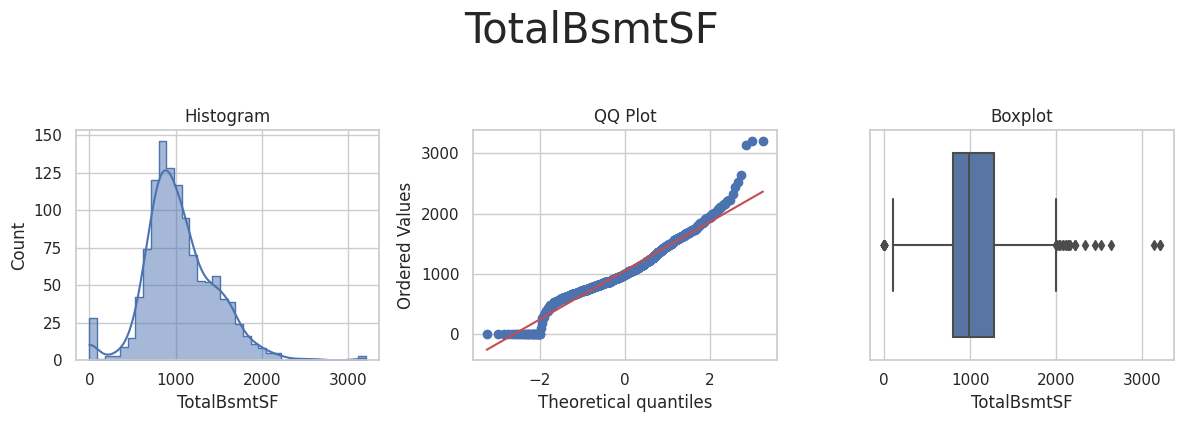

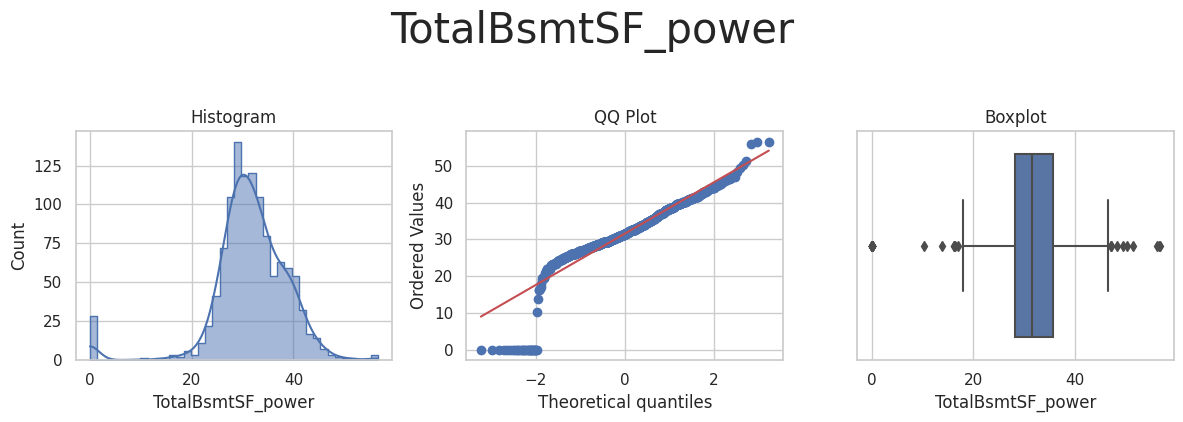

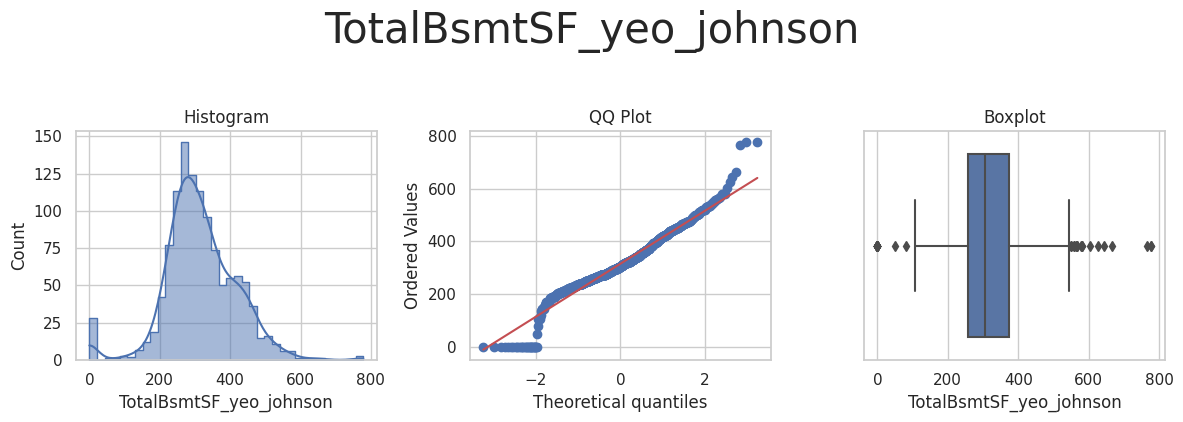



* Variable Analyzed: YearBuilt
* Applied transformation: ['YearBuilt_log_e', 'YearBuilt_log_10', 'YearBuilt_reciprocal', 'YearBuilt_power', 'YearBuilt_box_cox', 'YearBuilt_yeo_johnson'] 



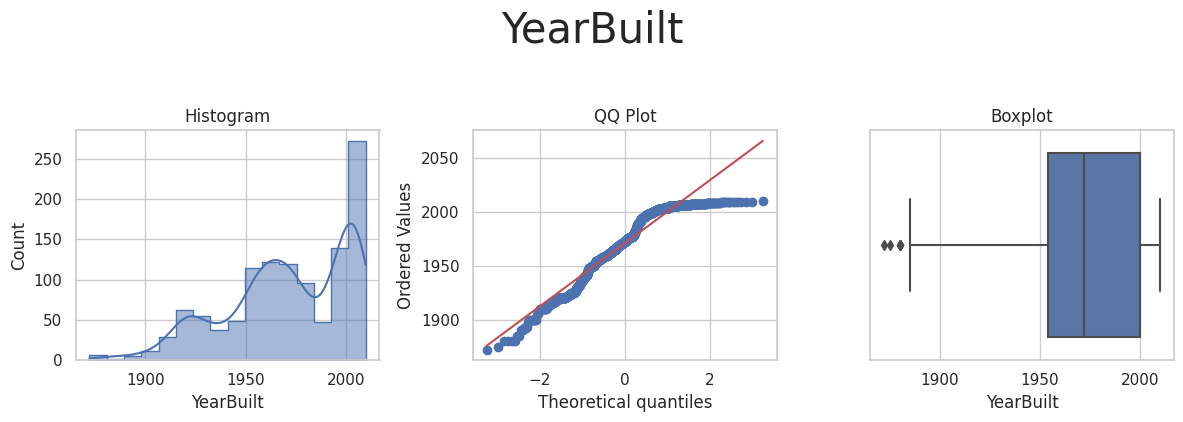

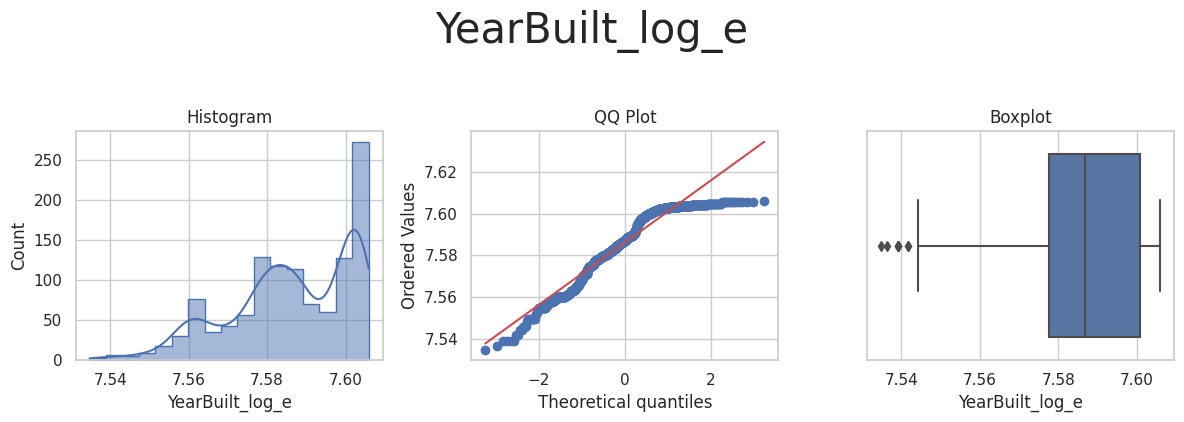

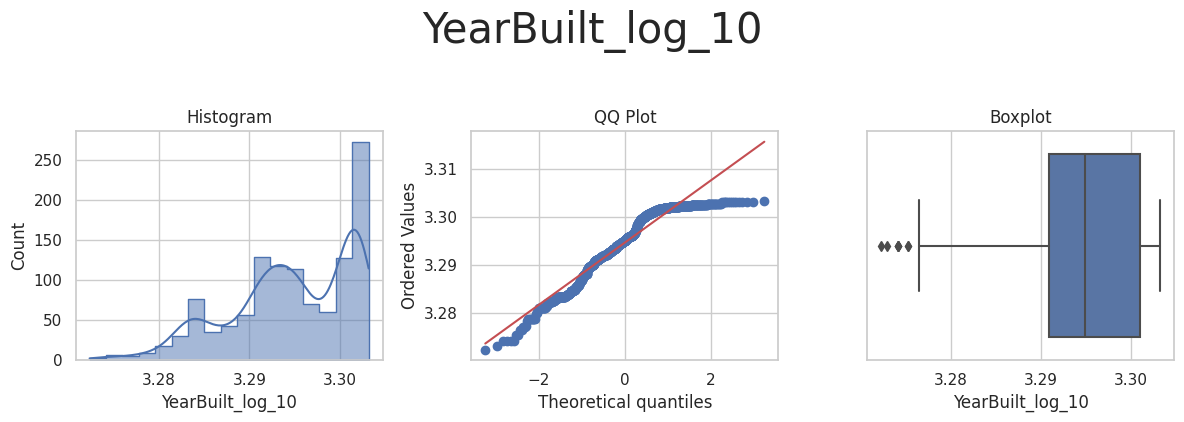

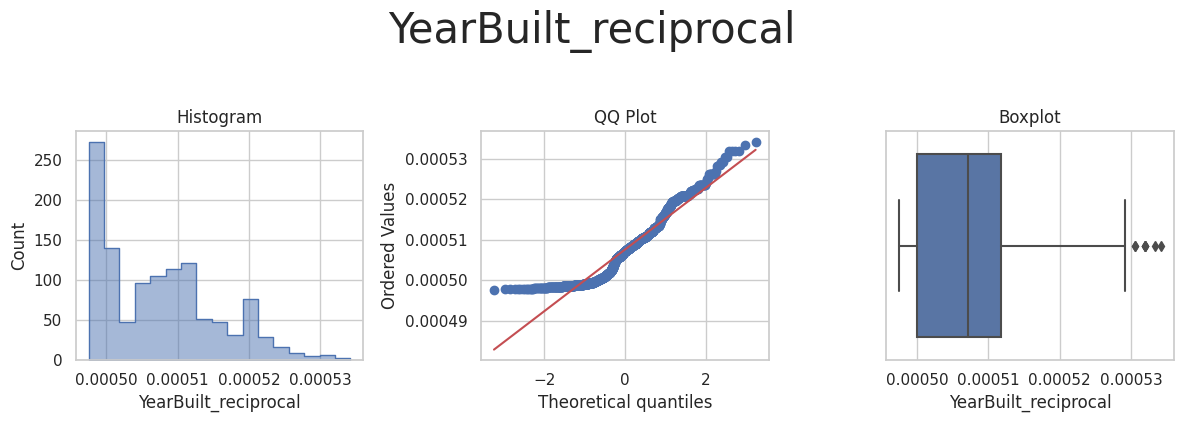

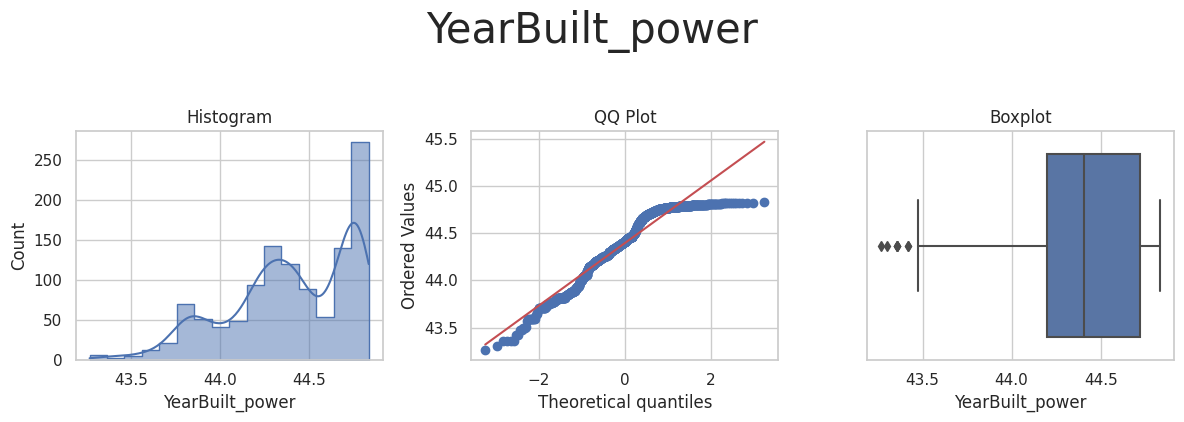

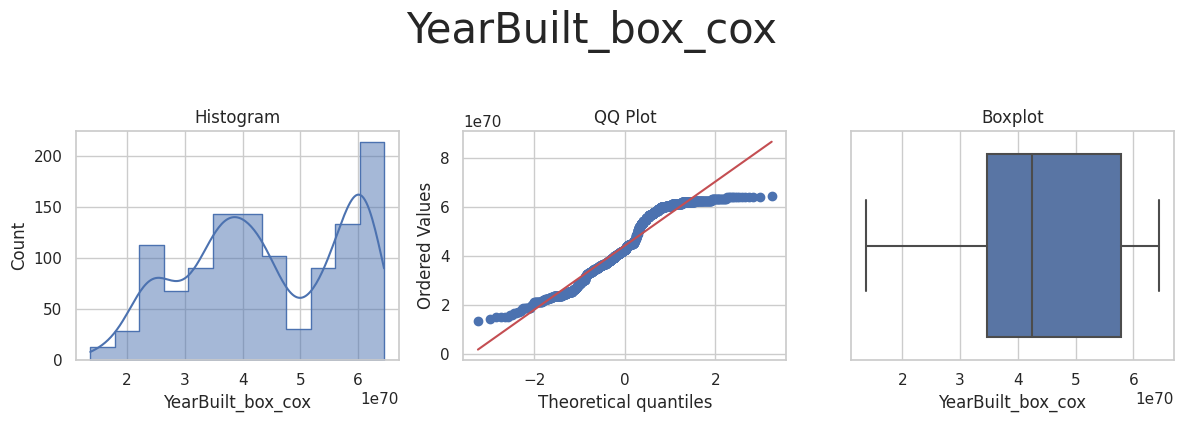

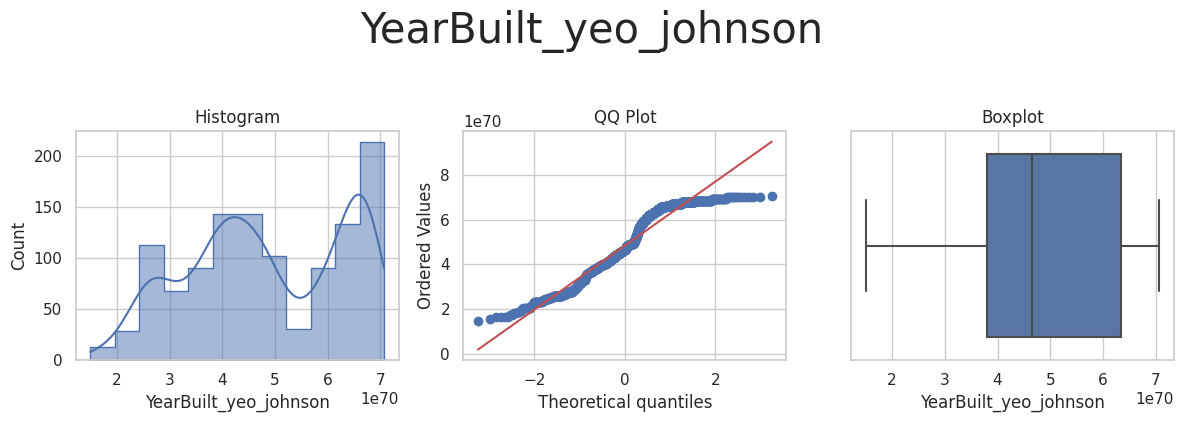



* Variable Analyzed: YearRemodAdd
* Applied transformation: ['YearRemodAdd_log_e', 'YearRemodAdd_log_10', 'YearRemodAdd_reciprocal', 'YearRemodAdd_power', 'YearRemodAdd_box_cox', 'YearRemodAdd_yeo_johnson'] 



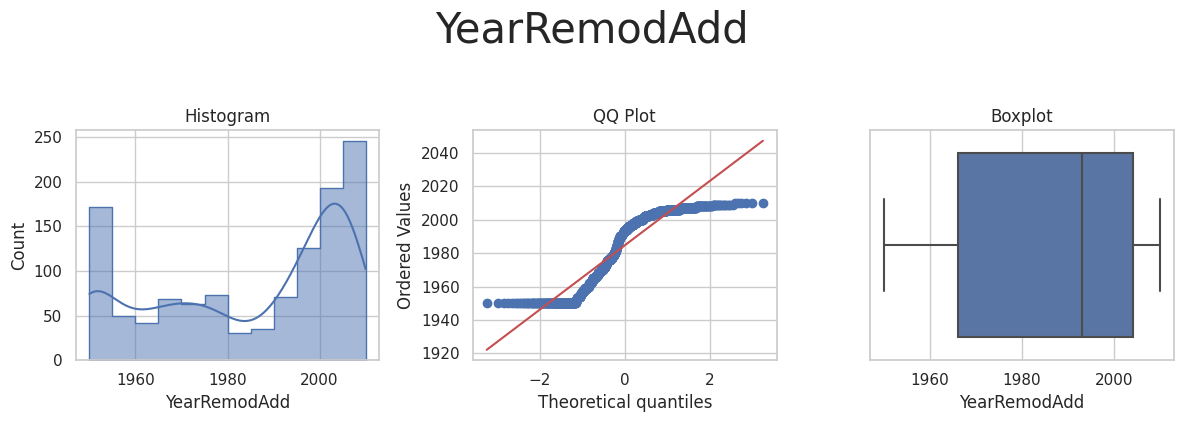

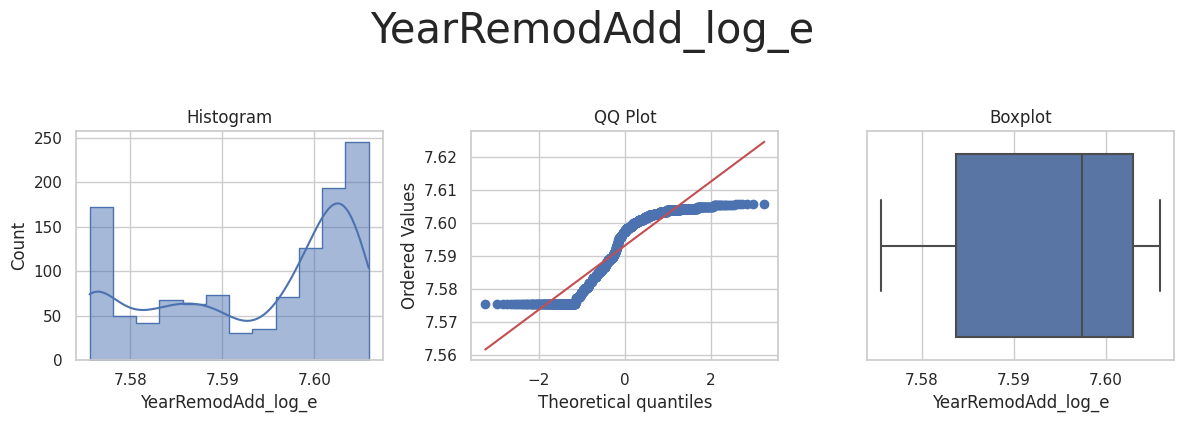

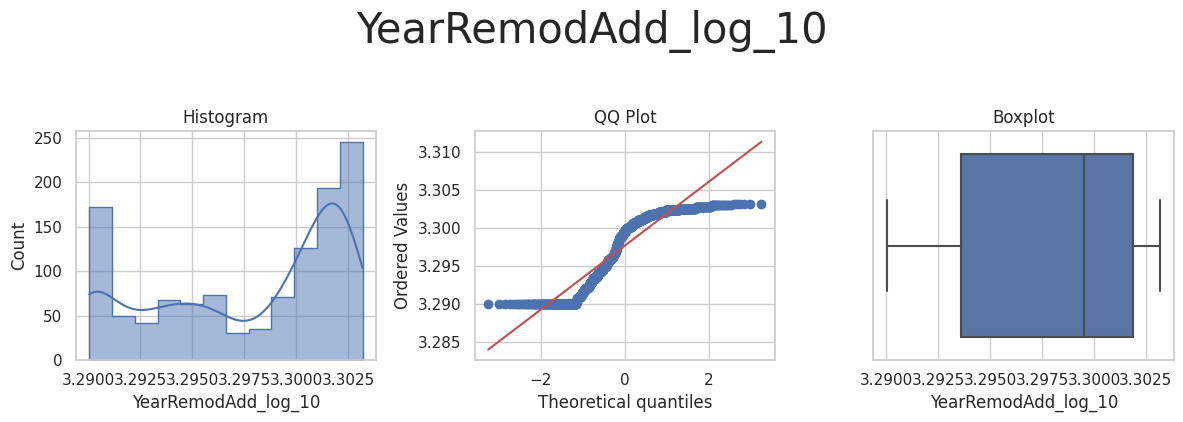

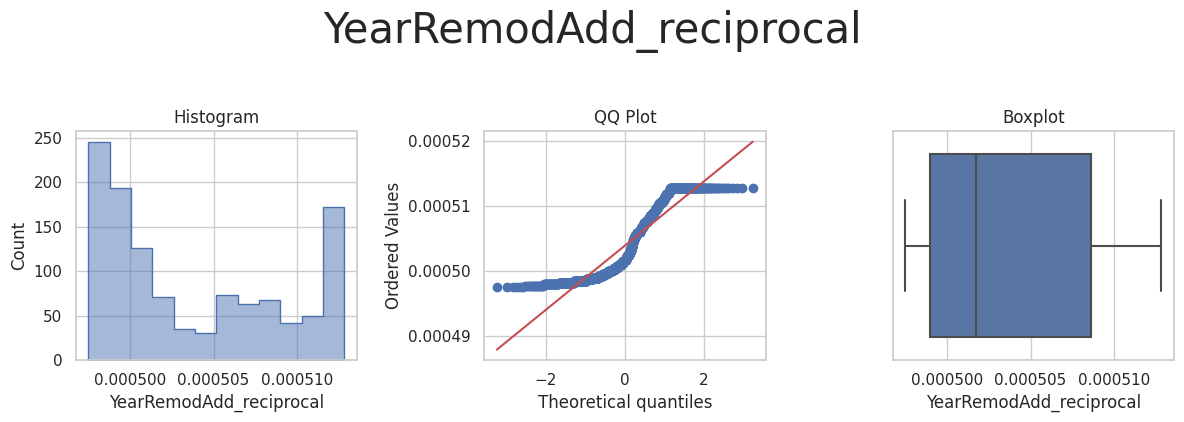

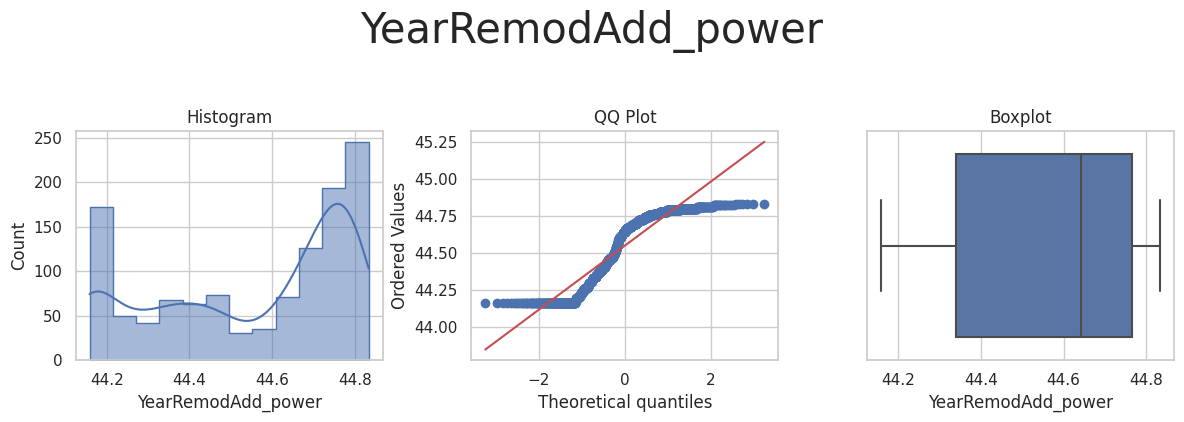

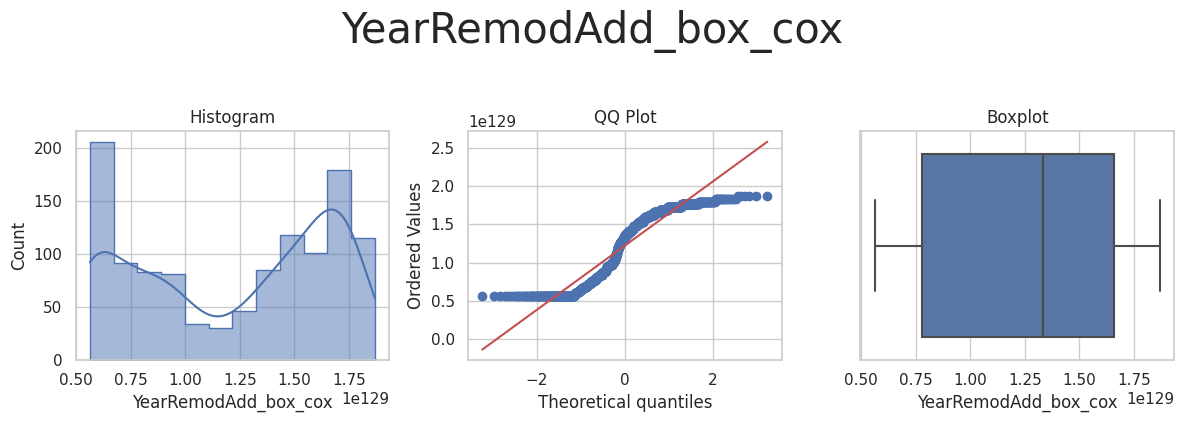

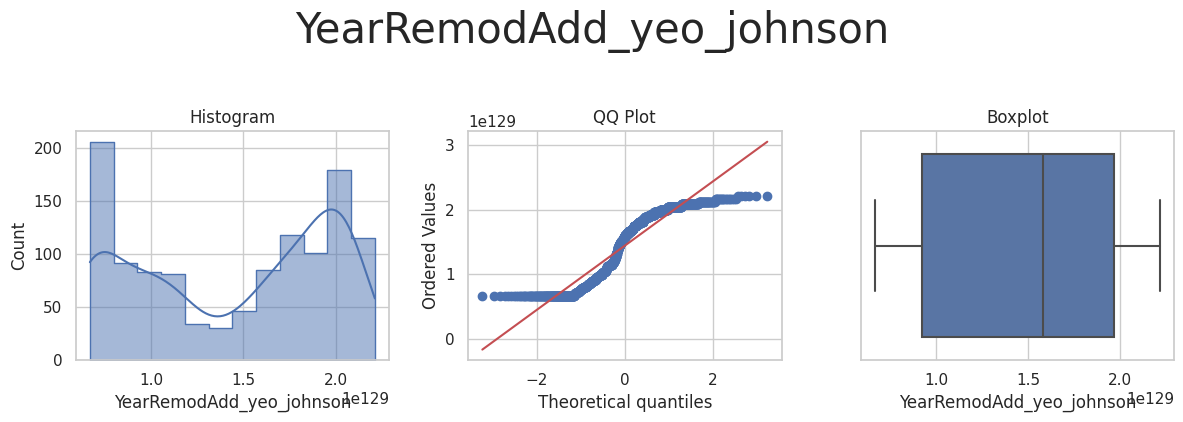

In [14]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

### Review of numerical transformation

| Feature      | Review | Transformation chosen |
| ----------- | ----------- | ----------- |
| 1stFlrSF      | A few transformation improved the distribution, especially log_e | Logarithmic in base e |
| GarageArea   | Yeo Johnson looks like the most effective  | Yeo Johnson |
| GarageYrBlt   | None of the transformations seems to be effective to normalise  | None |
| GrLivArea   | Yeo Johnson looks like the most effective  | Yeo Johnson |
| OverallQual   | None of the transformations seems to be effective to normalise  | None |
| TotalBsmtSF   | Power looks like the most effective once the ouliers are removed  | Power |
| YearBuilt   | None of the transformations seems to be effective to normalise  | None |
| YearRemodAdd   | None of the transformations seems to be effective to normalise  | None |


Transformation pipeline:

In [15]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ("LogTransformer", vt.LogTransformer(
        variables=['1stFlrSF'])),

    ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(
        variables=['GarageArea', 'GrLivArea'])),

    ("PowerTransformer", vt.PowerTransformer(
        variables=['TotalBsmtSF'])),
])

train_set = pipeline.fit_transform(TrainSet)
test_set = pipeline.transform(TestSet)

print("Numerical transformation done!")


Numerical transformation done!


## Smart Correlated Selection

Application of Smart correlated selection which finds multiple features correlated amongst themselves. I want to remove any surplus correlated features since they’ll add the same information to the model.

In [16]:
var_smart_corr_selection = (TrainSet.select_dtypes(
    include=['float', 'int']).columns.to_list())
var_smart_corr_selection.remove('SalePrice')
var_smart_corr_selection


['1stFlrSF',
 'GarageArea',
 'GarageYrBlt',
 'GrLivArea',
 'KitchenQual',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd']

In [17]:
df_smart_corr_selection = TrainSet[var_smart_corr_selection].copy()
df_smart_corr_selection.head(3)

1stFlrSF  GarageArea  GarageYrBlt  GrLivArea  KitchenQual  OverallQual  \
0      1828         774       2007.0       1828            0            9   
1       894         308       1962.0        894            1            5   
2       964         432       1921.0        964            1            5   

   TotalBsmtSF  YearBuilt  YearRemodAdd  
0         1822       2007          2007  
1          894       1962          1962  
2          876       1921          2006

In [18]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(
    variables=None, method="spearman", threshold=0.6, selection_method="variance")

corr_sel.fit_transform(df_engineering)
corr_sel.correlated_feature_sets_


[{'1stFlrSF',
  '1stFlrSF_box_cox',
  '1stFlrSF_log_10',
  '1stFlrSF_log_e',
  '1stFlrSF_power',
  '1stFlrSF_reciprocal',
  '1stFlrSF_yeo_johnson',
  'TotalBsmtSF',
  'TotalBsmtSF_power',
  'TotalBsmtSF_yeo_johnson'},
 {'GarageArea', 'GarageArea_power', 'GarageArea_yeo_johnson'},
 {'GarageYrBlt',
  'GarageYrBlt_box_cox',
  'GarageYrBlt_log_10',
  'GarageYrBlt_log_e',
  'GarageYrBlt_power',
  'GarageYrBlt_reciprocal',
  'GarageYrBlt_yeo_johnson',
  'YearBuilt',
  'YearBuilt_box_cox',
  'YearBuilt_log_10',
  'YearBuilt_log_e',
  'YearBuilt_power',
  'YearBuilt_reciprocal',
  'YearBuilt_yeo_johnson',
  'YearRemodAdd',
  'YearRemodAdd_box_cox',
  'YearRemodAdd_log_10',
  'YearRemodAdd_log_e',
  'YearRemodAdd_power',
  'YearRemodAdd_reciprocal',
  'YearRemodAdd_yeo_johnson'},
 {'GrLivArea',
  'GrLivArea_box_cox',
  'GrLivArea_log_10',
  'GrLivArea_log_e',
  'GrLivArea_power',
  'GrLivArea_reciprocal',
  'GrLivArea_yeo_johnson'},
 {'OverallQual',
  'OverallQual_box_cox',
  'OverallQual_log_1

In [19]:
corr_sel.features_to_drop_

['1stFlrSF',
 '1stFlrSF_log_e',
 '1stFlrSF_log_10',
 '1stFlrSF_reciprocal',
 '1stFlrSF_power',
 '1stFlrSF_box_cox',
 '1stFlrSF_yeo_johnson',
 'GarageArea_power',
 'GarageArea_yeo_johnson',
 'GarageYrBlt',
 'GarageYrBlt_log_e',
 'GarageYrBlt_log_10',
 'GarageYrBlt_reciprocal',
 'GarageYrBlt_power',
 'GarageYrBlt_box_cox',
 'GarageYrBlt_yeo_johnson',
 'GrLivArea_log_e',
 'GrLivArea_log_10',
 'GrLivArea_reciprocal',
 'GrLivArea_power',
 'GrLivArea_box_cox',
 'GrLivArea_yeo_johnson',
 'OverallQual_log_e',
 'OverallQual_log_10',
 'OverallQual_reciprocal',
 'OverallQual_power',
 'OverallQual_box_cox',
 'OverallQual_yeo_johnson',
 'TotalBsmtSF_power',
 'TotalBsmtSF_yeo_johnson',
 'YearBuilt',
 'YearBuilt_log_e',
 'YearBuilt_log_10',
 'YearBuilt_reciprocal',
 'YearBuilt_power',
 'YearBuilt_box_cox',
 'YearBuilt_yeo_johnson',
 'YearRemodAdd',
 'YearRemodAdd_log_e',
 'YearRemodAdd_log_10',
 'YearRemodAdd_reciprocal',
 'YearRemodAdd_power',
 'YearRemodAdd_box_cox']

The result is indicating that all features are highly correlated. For obvious reason we are not going to drop all the variables in the data set, I will move to the phase of modelling and evaluate the performance there empirically until the performance is accettable. If not I will return to this stage for further feature engineering.

---